In [1]:
from langchain_groq import ChatGroq
import os 
from dotenv import load_dotenv

load_dotenv()
llm = ChatGroq(
    temperature=0,
    groq_api_key = os.environ['GROQ_KEY'],
    model_name="llama-3.3-70b-versatile"
)

# result = llm.invoke("What is Langgraph?")
# print(result.content)
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [2]:
from pydantic import BaseModel, Field
from typing import List
from typing_extensions import TypedDict

class Question(BaseModel):
    question: str = Field(
        question="The question asked by the examiner",
    )
    @property
    def qn(self) -> str:
        return f"Question: {self.question}\n"

class Perspectives(BaseModel):
    questions: List[Question] = Field(
        description="List of questions asked by the examiner",
    )

class GenerateQuestionsState(TypedDict):
    grade: str # Grade that examiner teaches
    subject: str # Subject that examiner teaches
    max_questions: int # Number of questions
    human_feedback: str # Human feedback
    questions: List[Question] # Questions asked by examiner

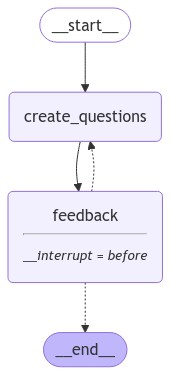

In [3]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

examiner_instructions="""You are an examiner tasked with creating questions that will have detailed answers. Follow these instructions carefully:

1. First, get the grade that the examiner teaches:
{grade}
        
2. Then, get the subject that the examiner teaches:
{subject}

3. Examine any feedback given to guide the creation of questions: 
        
{human_feedback}
    
4. Determine the questions appropriate for the grade and subject and consider human feedback if any.
                    
5. Return the top {max_questions} questions."""

def create_questions(state: GenerateQuestionsState):
    
    grade=state['grade']
    subject=state['subject']
    max_questions=state['max_questions']
    human_feedback=state.get('human_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = examiner_instructions.format(grade=grade,
                                                  subject=subject,
                                                  human_feedback=human_feedback, 
                                                  max_questions=max_questions)

    # Generate question 
    questions = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of questions.")])
    
    # Write the list of questionss to state
    return {"questions": questions.questions}

def feedback(state: GenerateQuestionsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateQuestionsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_feedback=state.get('human_feedback', None)
    if human_feedback:
        return "create_questions"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateQuestionsState)
builder.add_node("create_questions", create_questions)
builder.add_node("feedback", feedback)
builder.add_edge(START, "create_questions")
builder.add_edge("create_questions", "feedback")
builder.add_conditional_edges("feedback", should_continue, ["create_questions", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [4]:
grade = "8th"
subject = "history"
max_questions = 3
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream({"grade":grade,"subject":subject,"max_questions":max_questions}, thread, stream_mode="values"):
    # Review
    questions = event.get('questions', '')
    if questions:
        for idx,question in enumerate(questions):
            print(f"Question {idx}: {question.question}")
            print("-" * 50)  

Question 0: What were the primary causes of the American Revolution?
--------------------------------------------------
Question 1: How did the Industrial Revolution impact the daily lives of people in the 18th and 19th centuries?
--------------------------------------------------
Question 2: What were the major consequences of the Treaty of Versailles after World War I?
--------------------------------------------------


In [5]:
state = graph.get_state(thread)
state.next

('feedback',)

In [6]:
graph.update_state(thread, {"human_feedback": 
                            "Add one question related to India and rest for world"}, as_node="feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efda76f-219f-68c3-8002-1ddc9f2a7d0f'}}

In [7]:
for event in graph.stream({"grade":grade,"subject":subject,"max_questions":max_questions}, thread, stream_mode="values"):
    # Review
    questions = event.get('questions', '')
    if questions:
        for idx,question in enumerate(questions):
            print(f"Question{idx}: {question.question}")
            print("-" * 50)  

Question0: What were the primary causes of the American Revolution?
--------------------------------------------------
Question1: How did the Industrial Revolution impact the daily lives of people in the 18th and 19th centuries?
--------------------------------------------------
Question2: What were the major consequences of the Treaty of Versailles after World War I?
--------------------------------------------------
Question0: What were the major factors that led to the Indian independence movement?
--------------------------------------------------
Question1: How did the ancient civilizations of Egypt and Mesopotamia contribute to the development of modern society?
--------------------------------------------------
Question2: What were the primary causes and consequences of World War II?
--------------------------------------------------


In [8]:
further_feedack = None
graph.update_state(thread, {"human_feedback": 
                            further_feedack}, as_node="feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efda76f-7435-6e14-8006-c026d1615290'}}

In [9]:
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [10]:
final_state = graph.get_state(thread)
final_state.next

()

In [11]:
import operator
from typing import  Annotated

class AnswerState(TypedDict):
    context: Annotated[list, operator.add]
    question: Question
    sections: list

In [12]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=2)
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

In [13]:
from langchain_core.messages import get_buffer_string

def search_web(state: AnswerState):
    
    """ Retrieve docs from web search """
    question = state["question"]
    # Search
    search_query = question.question
    search_docs = tavily_search.invoke(search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: AnswerState):
    
    """ Retrieve docs from wikipedia """
    
    question = state["question"]
    # Search
    search_query = question.question
    search_docs = WikipediaLoader(query=search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

In [14]:
section_writer_instructions = ''' You are a student tasked with writing a detailed answer for the question:{question}
Write the answer in markdown format using 
# for headings
## for subheadings '''
def write_section(state: AnswerState):

    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(question=question.question)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

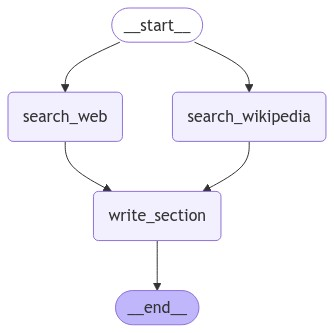

In [15]:
answer_builder = StateGraph(AnswerState)
answer_builder.add_node("search_web", search_web)
answer_builder.add_node("search_wikipedia", search_wikipedia)
answer_builder.add_node("write_section", write_section)

answer_builder.add_edge(START, "search_web")
answer_builder.add_edge(START, "search_wikipedia")
answer_builder.add_edge("search_web", "write_section")
answer_builder.add_edge("search_wikipedia", "write_section")
answer_builder.add_edge("write_section", END)

memory = MemorySaver()
answer_graph = answer_builder.compile(checkpointer=memory).with_config(run_name="Get answers")

# View
display(Image(answer_graph.get_graph().draw_mermaid_png()))

In [16]:
questions = final_state.values.get('questions')
questions[0]

Question(question='What were the major factors that led to the Indian independence movement?')

In [17]:
from IPython.display import Markdown
thread = {"configurable": {"thread_id": "1"}}
interview = answer_graph.invoke({"question":questions[0]}, thread)
Markdown(interview['sections'][0])

# Introduction to the Indian Independence Movement
The Indian independence movement was a series of historic events in South Asia with the ultimate aim of ending British colonial rule. It lasted until 1947, when the Indian Independence Act 1947 was passed.

## Background of British Colonialism in India
The first European to reach India via the Atlantic Ocean was the Portuguese explorer Vasco da Gama, who reached Calicut in 1498 in search of spice. Just over a century later, the Dutch and English established trading outposts on the Indian subcontinent, with the first English trading post set up at Surat in 1613. Over the next two centuries, the British defeated the Portuguese and Dutch but remained in conflict with the French. The decline of the Mughal Empire in the first half of the eighteenth century allowed the British to establish a foothold in Indian politics.

## Early Independence Movements
Maveeran Alagumuthu Kone was an early revolutionary against the British presence in Tamil Nadu. He became a military leader in the town of Ettayapuram and was defeated in battle against the British and Maruthanayagam's forces. He was executed in 1757. Puli Thevar opposed the Nawab of Arcot, who was supported by the British. Maruthanayagam Pillai was another early revolutionary who fought against the British.

## The Rise of Nationalism and the Indian National Congress
The first nationalistic movement for Indian independence emerged in the Province of Bengal. It later took root in the newly formed Indian National Congress with prominent moderate leaders seeking the right to appear for Indian Civil Service examinations in British India, as well as more economic rights for natives. The first half of the 20th century saw a more radical approach towards self-rule.

## Major Factors Leading to the Indian Independence Movement
Several factors contributed to the Indian independence movement, including:
* The growth of Muslim separatism from the late 19th century
* The rise of communal violence from the 1920s to the virulent outbreaks of 1946-1947
* The exploitation of India's resources by the British, with India generating large amounts of wealth for England
* The introduction of the Rowlatt Act, which permitted indefinite detention and sparked protests across India
* The Jallianwala Bagh massacre, which violently suppressed protests in the Punjab Province

## Key Leaders and Movements
Mahatma Gandhi played a significant role in the Indian independence movement, leading the Salt Satyagraha and promoting non-violence and civil disobedience. Other key leaders included Jawaharlal Nehru, Vallabhbhai Patel, Abdul Ghaffar Khan, and Maulana Azad. The Revolutionary movement for Indian Independence, comprising violent underground revolutionary factions, also contributed to the movement.

## Regional Movements
Regional movements, such as the Anushilan Samiti in Bengal and the Communist Consolidation in Andhra Pradesh, also played a significant role in the Indian independence movement. The Andaman Island was also a hub for revolutionary activities, with the formation of the Communist Consolidation organization in the Cellular Jail.

## Conclusion
The Indian independence movement was a complex and multifaceted phenomenon, driven by a range of factors and led by a diverse group of individuals and organizations. The movement ultimately culminated in the Indian Independence Act 1947, which ended Crown suzerainty and partitioned British India into the Dominion of India and the Dominion of Pakistan.